# Turbulence numerical explorations
## Lecture 2

Author: Enrico Calzavarini enrico.calzavarini@univ-lille.fr

We look at the velocity and velocity gradients single-point statistics


First we read turbulent flow field data from a **hdf5** file. 

In [1]:
from math import *
import numpy as np
import h5py

fname="../HIT_128/field_10000.h5"
f = h5py.File( fname,'r')

vx=np.array(f['euler']['velocity_x'])
vy=np.array(f['euler']['velocity_y'])
vz=np.array(f['euler']['velocity_z'])

NZ = vx.shape[0]
NY = vx.shape[1]
NX = vx.shape[2]
print(NX,NY,NZ)

128 128 128


In [30]:
# compute the mean kinetic energy and its typical fluctuation
kinetic_energy = (vx*vx + vy*vy + vz*vz)/2.
mean_kinetic_energy = np.mean(kinetic_energy)
std_kinetic_energy = np.std(kinetic_energy)
print("mean kinetic energy = "+str(mean_kinetic_energy))
print("standard deviation of kinetic energy = "+str(std_kinetic_energy))

mean kinetic energy = 0.0032275040614927544
standard deviation of kinetic energy = 0.0025361828284862368


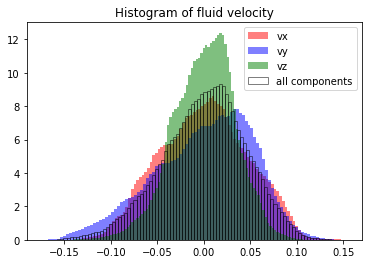

In [31]:
# Check the shape of the distribution of velocity cartesian components
# make a single array
import matplotlib.pyplot as plt
a = np.reshape(vx-np.mean(vx), (NX*NY*NZ))
b = np.reshape(vy-np.mean(vy), (NX*NY*NZ))
c = np.reshape(vz-np.mean(vz), (NX*NY*NZ))
d = np.concatenate((a,b,c), axis=0)
bins = 100
plt.hist(a, bins, density=True, facecolor='r', alpha=0.5,label='vx' )
plt.hist(b, bins, density=True, facecolor='b', alpha=0.5,label='vy' )
plt.hist(c, bins, density=True, facecolor='g', alpha=0.5,label='vz')
plt.hist(d, bins, density=True, facecolor='y', alpha=0.5,label='all components',fill=False)
plt.title("Histogram of fluid velocity")
plt.legend(loc='upper right')  
plt.show()

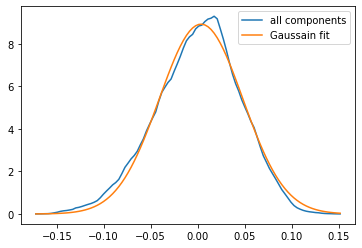

Fitted mean = 0.0036200420366536063
Fitted standard deviation = -0.044490266610951554


In [39]:
# Fit with a Gaussian
from scipy.optimize import curve_fit

# Define some test data which is close to Gaussian 
# here is all components
hist, bin_edges = np.histogram(d, bins, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]
# fitting the curve
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='all components')
#plt.hist(d, bins, density=True, facecolor='y', alpha=0.5,label='all components',fill=False)
plt.plot(bin_centres, hist_fit, label='Gaussain fit')
plt.legend(loc='upper right') 
plt.show()

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = '+str(coeff[1]))
print( 'Fitted standard deviation = '+str( coeff[2]))

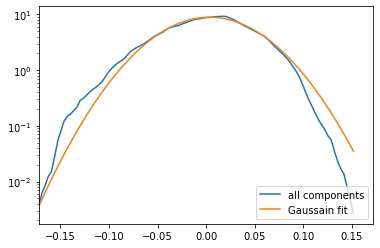

In [24]:
plt.plot(bin_centres, hist, label='all components')
plt.plot(bin_centres, hist_fit, label='Gaussain fit')
plt.yscale("log")
plt.legend(loc='lower right') 
lim = np.max(np.abs(bin_centres))
plt.xlim([-lim,lim])
plt.show()

## Question 1: 
Are velocity components statistically independent? 

*Show it with a plot and by computing their correlation matrix.*


You can use

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

and 
https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

## Calculation of the Kolmogorov scales

In [41]:
nu = 0.025/3. # valuue of viscosity in the simulation of our dataset. 

epsilon = np.zeros((NX,NY,NZ))

dvx = np.gradient(vx,edge_order=2)
dvy = np.gradient(vy,edge_order=2)
dvz = np.gradient(vz,edge_order=2)
# we use more handy names
dxvx, dyvx, dzvx = dvx[2],dvx[1],dvx[0]
dxvy, dyvy, dzvy = dvy[2],dvy[1],dvy[0]
dxvz, dyvz, dzvz = dvz[2],dvz[1],dvz[0]

epsilon = ( (dxvx + dxvx)**2. +  (dyvx + dxvy)**2. + (dzvx + dxvz)**2. + 
                     (dxvy + dyvx)**2. +  (dyvy + dyvy)**2. + (dzvy + dyvz)**2. +
                     (dxvz + dzvx)**2. +  (dyvz + dzvy)**2. + (dzvz + dzvz)**2. )*nu/2.             


#kinetic_energy = (vx*vx + vy*vy + vz*vz)/2.
mean_energy_dissipation = np.mean(epsilon)
print("mean energy dissipation rate = "+str(mean_energy_dissipation))
# Kolmogorov scales
eta = (nu**(3./4.))/(mean_energy_dissipation**(1./4.))
tau_eta = (nu**(1./2.))/(mean_energy_dissipation**(1./2.))
u_eta = eta / tau_eta
print("eta = "+str(eta))
print("tau_eta = "+str(tau_eta))
print("u_eta = "+str(u_eta))
# check
print("Re @ Kolmogorov scale = "+str(u_eta*eta/nu))

mean energy dissipation rate = 8.013738315881689e-07
eta = 0.9218394214092098
tau_eta = 101.974550263688
u_eta = 0.009039896905899535
Re @ Kolmogorov scale = 1.0


## Calculation of the Taylor scale and Reynolds number

In [19]:
#u_rms = np.sqrt(np.mean(vx*vx)) 
u_rms = np.std(vx) 

gradient = np.zeros((NX,NY,NZ))
for i in range(NX):
    for j in range(NY):
        for k in range(NZ):
            #compute the velocity gradient
            ip = 0 if (i+1==NX) else i+1
            im = NX-1 if (i==0) else i-1              
            gradient[i][j][k]= (vx[ip][j][k] - vx[im][j][k])/2.
dxvx_rms = np.std(gradient) 

l_taylor = u_rms / dxvx_rms
print("l_taylor = "+str(l_taylor))
Re_taylor = u_rms * l_taylor / nu
print("Re_taylor = "+str(Re_taylor))

l_taylor = 12.089851916087035
Re_taylor = 67.86937746665703


## Statistics of the energy disspation rate

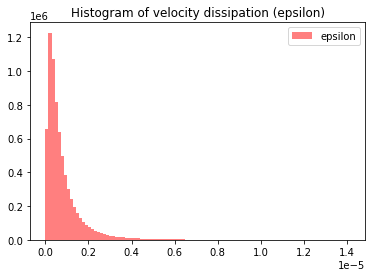

In [20]:
# Check the shape of the distribution of the kinetic energy dissiaption rate 
# make a single array
a = np.reshape(epsilon, (NX*NY*NZ))
bins = 100
plt.hist(a, bins, density=True, facecolor='r', alpha=0.5,label='epsilon' )
plt.title("Histogram of velocity dissipation (epsilon)")
plt.legend(loc='upper right')  
plt.show()

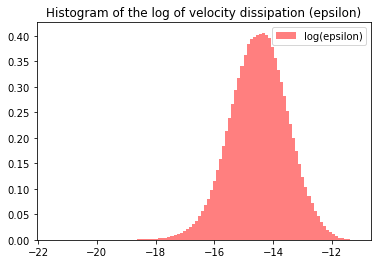

In [21]:
plt.hist(np.log(a), bins, density=True, facecolor='r', alpha=0.5,label='log(epsilon)' )
plt.title("Histogram of the log of velocity dissipation (epsilon)")
plt.legend(loc='upper right') 
plt.show()

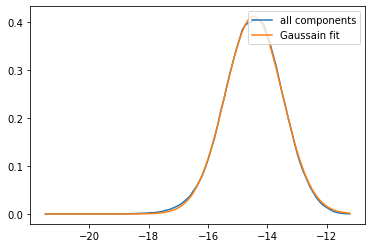

Fitted mean = -14.457972567084475
Fitted standard deviation = 0.9645222530284697


In [22]:
# Fit with a Gaussian
from scipy.optimize import curve_fit
# Define some test data which is close to Gaussian
data = np.log(a) 
hist, bin_edges = np.histogram(data, bins, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
#mu=np.mean(np.log(epsilon))
#sigma=np.std(np.log(epsilon))
#A=(1./np.sqrt(2.*np.pi)*sigma)
#print(A,mu,sigma)
#p0=[A,mu,sigma]
#0.3960116891274831 -14.26864355662316 0.992654097051331
p0 = [0.5, -10, 1.]
# fitting the curve
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='all components')
plt.plot(bin_centres, hist_fit, label='Gaussain fit')
plt.legend(loc='upper right') 
plt.show()

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = '+str(coeff[1]))
print( 'Fitted standard deviation = '+str( coeff[2]))

## Question 2:
Are the velocity gradient components statistically independent?

show it with by computing their correlation coefficients.